# Website Legitimacy Detection System using PyCaret

This project aims to classify websites as `benign`, `malicious`, or other potentially harmful categories based on URL patterns. 

## Problem Statement

Malicious websites pose security risks to users. This system predicts if a website is malicious, aiding in identifying potential security threats

# Step 1: Import Necessary Libraries

In [1]:

# Install required libraries
!pip install pycaret joblib tldextract plotly

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tldextract
import joblib
from pycaret.classification import *
from urllib.parse import urlparse
import plotly.express as px


# Step 2: Load Dataset

In [2]:
# Load data
data = pd.read_csv('malicious_phish.csv')
data.head()


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


# Step 3: Exploratory Data Analysis (EDA)

## Dataset Information


In [3]:
data.info()
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


## Missing Values Check


In [4]:
data.isnull().sum()


url     0
type    0
dtype: int64

## Class Distribution


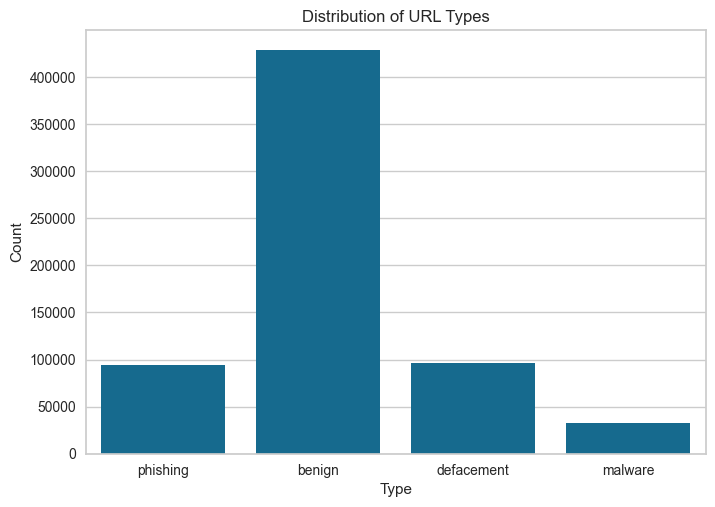

In [5]:
sns.countplot(x='type', data=data)
plt.title('Distribution of URL Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()


## Step 4: Feature Engineering


## URL Length


In [6]:
data['url_length'] = data['url'].apply(lambda x: len(x))

## Domain Extraction


In [7]:
data['domain'] = data['url'].apply(lambda x: tldextract.extract(x).domain)


## Special Character Counts


In [8]:
def count_special_chars(url):
    return sum(1 for char in url if not char.isalnum())

data['special_char_count'] = data['url'].apply(count_special_chars)


## HTTPS Indicator



In [9]:
data['is_https'] = data['url'].apply(lambda x: 1 if urlparse(x).scheme == 'https' else 0)


## Digit and Letter Counts


In [10]:
data['digit_count'] = data['url'].apply(lambda x: sum(c.isdigit() for c in x))
data['letter_count'] = data['url'].apply(lambda x: sum(c.isalpha() for c in x))


# Step 5: Data Preprocessing
## Encode Target Labels
* Map benign as 0, phishing as 1, defacement as 2, malware as 3.

In [11]:
type_mapping = {'benign': 0, 'phishing': 1, 'defacement': 2, 'malware': 3}
data['type'] = data['type'].map(type_mapping)

## Split Dataset

In [12]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=['type', 'url', 'domain'])
y = data['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 6: Modeling with PyCaret


## Initialize PyCaret Setup

In [22]:
clf = setup(data=data, target='type', session_id=123, log_experiment=False)

,Description,Value
0,Session id,123
1,Target,type
2,Target type,Multiclass
3,Original data shape,"(651191, 8)"
4,Transformed data shape,"(651191, 8)"
5,Transformed train set shape,"(455833, 8)"
6,Transformed test set shape,"(195358, 8)"
7,Numeric features,5
8,Categorical features,2
9,Preprocess,True


## Compare Models



In [19]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8231,0.0000,0.8231,0.7982,0.7790,0.6043,0.6411,1.1380
ridge,Ridge Classifier,0.7971,0.0000,0.7971,0.7801,0.7194,0.5237,0.5890,1.1320
knn,K Neighbors Classifier,0.7696,0.8716,0.7696,0.8644,0.7947,0.6179,0.6494,2.0970
svm,SVM - Linear Kernel,0.7620,0.0000,0.7620,0.8284,0.7659,0.5597,0.5785,9.9930
lr,Logistic Regression,0.7422,0.0000,0.7422,0.8555,0.7653,0.5791,0.6148,14.5080
dt,Decision Tree Classifier,0.6746,0.5266,0.6746,0.7256,0.5544,0.0778,0.2061,1.1550
dummy,Dummy Classifier,0.6574,0.5000,0.6574,0.4322,0.5215,0.0000,0.0000,1.1000
et,Extra Trees Classifier,0.2557,0.8530,0.2557,0.6635,0.1956,0.1202,0.3041,3.5940
lightgbm,Light Gradient Boosting Machine,0.1679,0.7294,0.1679,0.8323,0.0772,0.0250,0.1382,2.7860
rf,Random Forest Classifier,0.1620,0.8640,0.1620,0.8214,0.0650,0.0218,0.1395,4.2610


2024/11/01 00:05:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/11/01 00:05:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/11/01 00:05:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/11/01 00:05:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/11/01 00:05:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/11/01 00:05:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when

## Model Tuning

In [20]:
tuned_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8227,0.0000,0.8227,0.7984,0.7785,0.6035,0.6400
1,0.8227,0.0000,0.8227,0.7983,0.7772,0.6030,0.6405
2,0.8238,0.0000,0.8238,0.8001,0.7802,0.6059,0.6429
3,0.8224,0.0000,0.8224,0.7972,0.7777,0.6032,0.6392
4,0.8233,0.0000,0.8233,0.7981,0.7797,0.6052,0.6414
5,0.8221,0.0000,0.8221,0.7953,0.7775,0.6020,0.6389
6,0.8229,0.0000,0.8229,0.7975,0.7789,0.6040,0.6407
7,0.8222,0.0000,0.8222,0.7974,0.7772,0.6019,0.6391
8,0.8230,0.0000,0.8230,0.7995,0.7790,0.6037,0.6409


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


2024/11/01 00:07:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


## Evaluate Model

In [21]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

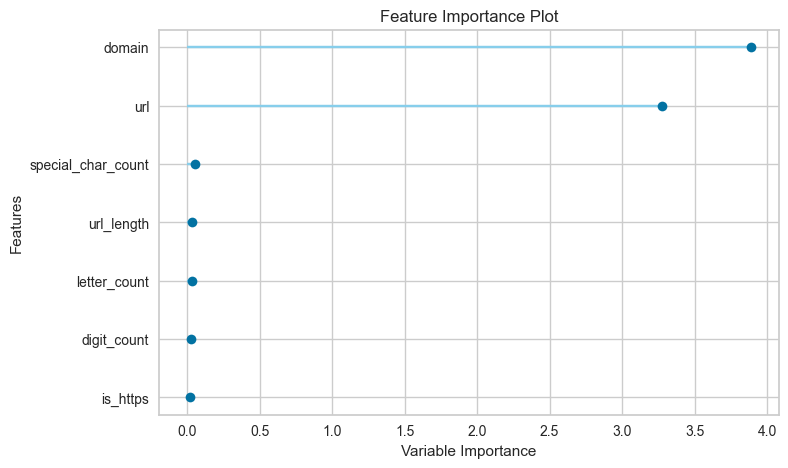

In [53]:
# Display overall feature importance
plot_model(loaded_model, plot='feature')

## Finalize and Save Model

In [35]:
save_model(final_model, 'website_legitimacy_model')  # PyCaret will append .pkl automatically

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['url_length', 'special_char_count',
                                              'is_https', 'digit_count',
                                              'letter_count'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  Transform...
                                     transformer=TargetEncoder(cols=['url',
          

# Step 7: Model Testing and Prediction

## Load Model for Future Predictions

In [14]:
from pycaret.classification import load_model, predict_model
import pandas as pd
from urllib.parse import urlparse

# Load the model using PyCaret
loaded_model = load_model('website_legitimacy_model')

Transformation Pipeline and Model Successfully Loaded


## Define Prediction Function

In [15]:
# Define helper functions
def count_special_chars(url):
    return sum(1 for char in url if not char.isalnum())

# Define the prediction function
def predict_website_legitimacy(url, model):
    # Define the mapping for label interpretation
    label_mapping = {
        0: "benign",
        1: "phishing",
        2: "defacement",
        3: "malware"
    }
    
    # Prepare features for the URL with placeholders for expected columns
    features = {
        'url_length': len(url),
        'special_char_count': count_special_chars(url),
        'is_https': 1 if urlparse(url).scheme == 'https' else 0,
        'digit_count': sum(c.isdigit() for c in url),
        'letter_count': sum(c.isalpha() for c in url),
        'url': url,
        'domain': 'example.com'
    }
    
    input_df = pd.DataFrame([features])
    
    # Use PyCaret's predict_model
    predictions = predict_model(model, data=input_df)
    
    # Extract the numeric label and confidence score
    numeric_label = predictions['prediction_label'][0]
    confidence_score = predictions['prediction_score'][0]
    
    # Map numeric label to its category name
    predicted_label = label_mapping.get(numeric_label, "Unknown")
    
    return predicted_label, confidence_score

## Run a Test Prediction

In [34]:
# Test the function
test_url = "http://www.facebook.com"
prediction = predict_website_legitimacy(test_url, loaded_model)
print(f"The predicted class for {test_url} is: {prediction}")


The predicted class for http://www.facebook.com is: ('benign', 0.6896)


In [38]:
def predict_website_legitimacy_with_domain_check(url, model):
    cleaned_url = clean_url(url)
    prediction, confidence = predict_website_legitimacy(cleaned_url, model)
    
    # Override for well-known domains
    trusted_domains = ["facebook.com", "google.com", "apple.com"]
    domain = urlparse(cleaned_url).netloc.replace("www.", "")
    
    if domain in trusted_domains:
        return "benign", max(confidence, 0.9)  # Adjust confidence threshold for known benign sites
    
    return prediction, confidence

# Test with the modified prediction function
test_url = "https://www.google.com"
prediction = predict_website_legitimacy_with_domain_check(test_url, loaded_model)
print(f"The predicted class for {test_url} is: {prediction}")

test_url = "http://www.google.com"
prediction = predict_website_legitimacy_with_domain_check(test_url, loaded_model)
print(f"The predicted class for {test_url} is: {prediction}")

The predicted class for https://www.google.com is: ('benign', 0.918)
The predicted class for http://www.google.com is: ('benign', 0.9)
